## PCA: Principle Component Analysis
Reference  
[Dr.Sebastian Raschka's blog](https://sebastianraschka.com/Articles/2015_pca_in_3_steps.html)

In [1]:
import csv
import pandas as pd
import numpy as np
import maths
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
pd.set_option("display.max_rows", 10)

/Users/takumkawahara/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Reading in the dataset

In [2]:
df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how="all", inplace=True) # drops the empty line at file-end
df

,sepal_len,sepal_wid,petal_len,petal_wid,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [67]:
df.describe()

,sepal_len,sepal_wid,petal_len,petal_wid
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
# split data table into data X and class labels y
X = df.iloc[:,0:4].values
y = df.iloc[:,4].values

## Data visualization

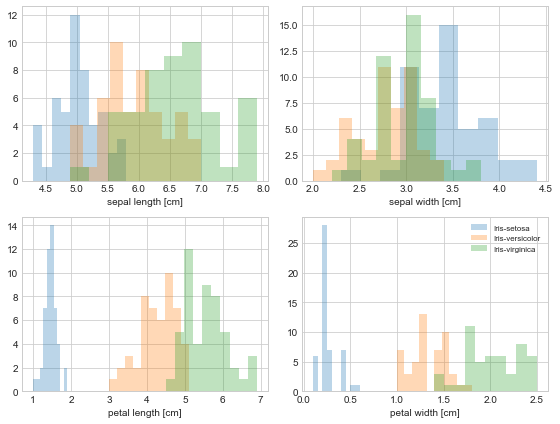

In [8]:
label_dict = {1: 'Iris-Setosa',
              2: 'Iris-Versicolor',
              3: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for cnt in range(4):
        plt.subplot(2, 2, cnt+1)
        for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(X[y==lab, cnt],
                     label=lab,
                     bins=10,
                     alpha=0.3,)
        plt.xlabel(feature_dict[cnt])
    plt.legend(loc='upper right', fancybox=True, fontsize=8)

    plt.tight_layout()
    plt.show()

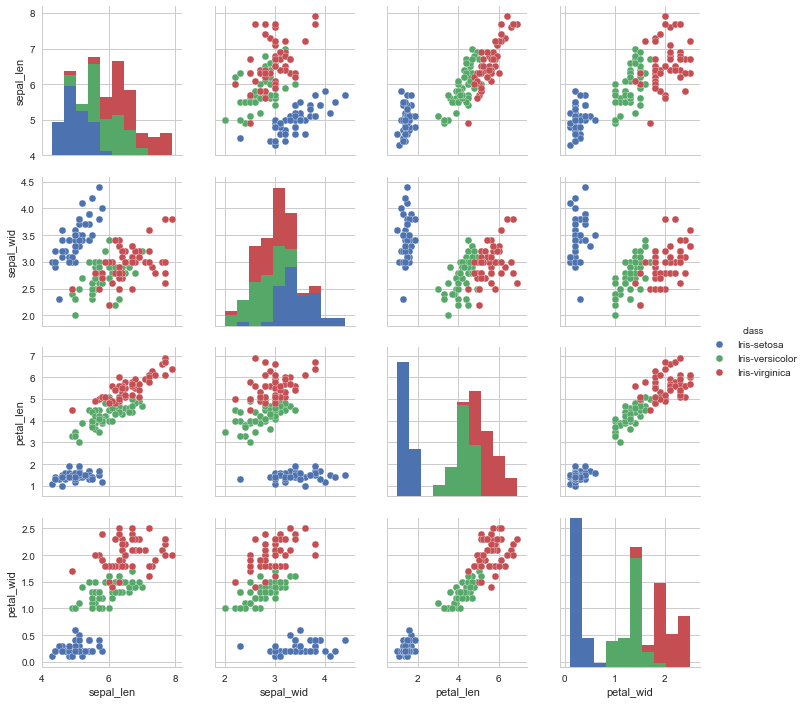

In [36]:
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df, size=2.5, hue='class')
plt.show()

## Standardizing

In [81]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

## Covariance Matrix

In [11]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


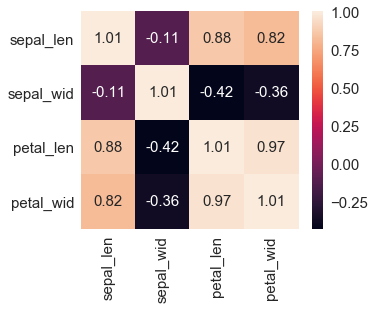

In [18]:
sns.set(font_scale=1.5)
plt.subplots(figsize=(5,4))
hm = sns.heatmap(cov_mat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15}, xticklabels=df.columns[:4], yticklabels=df.columns[:4])
plt.show()

In [20]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[ 2.93035378  0.92740362  0.14834223  0.02074601]


# Selecting Principal Components  
## Sorting Eigenpairs

In [21]:
for ev in eig_vecs.T:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In [22]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
2.93035377559
0.927403621517
0.148342226482
0.0207460139956


## Explained Variance

In [23]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

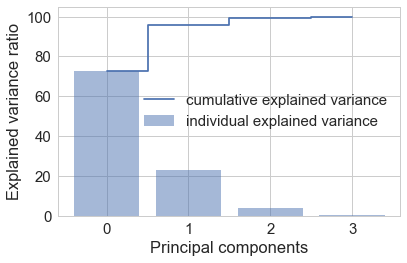

In [24]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(4), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

## Projection Matrix

In [25]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1),
                      eig_pairs[1][1].reshape(4,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


In [90]:
abs(eig_pairs[0][1])

array([ 0.52237162,  0.26335492,  0.58125401,  0.56561105])

In [92]:
eig_pairs[0][1][0]**2+eig_pairs[0][1][1]**2+eig_pairs[0][1][2]**2+eig_pairs[0][1][3]**2

1.0000000000000002

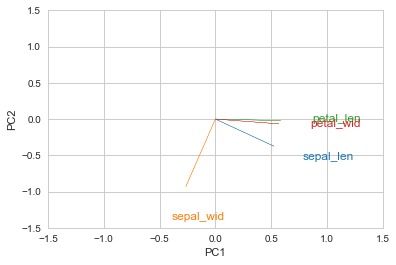

In [66]:
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
for i in range(eig_pairs[0][1].shape[0]):
    plt.arrow(0, 0, eig_pairs[0][1][i], eig_pairs[1][1][i], color=new_colors[i])
    plt.text(eig_pairs[0][1][i]*1.5, eig_pairs[1][1][i]*1.5, df.columns[i],color=new_colors[i])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Projection Onto the New Feature Space

In [26]:
Y = X_std.dot(matrix_w)

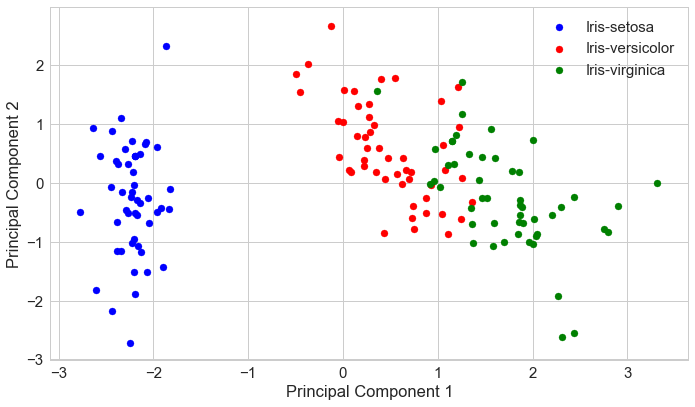

In [30]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 6))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

## Shortcut - PCA in scikit-learn

In [31]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

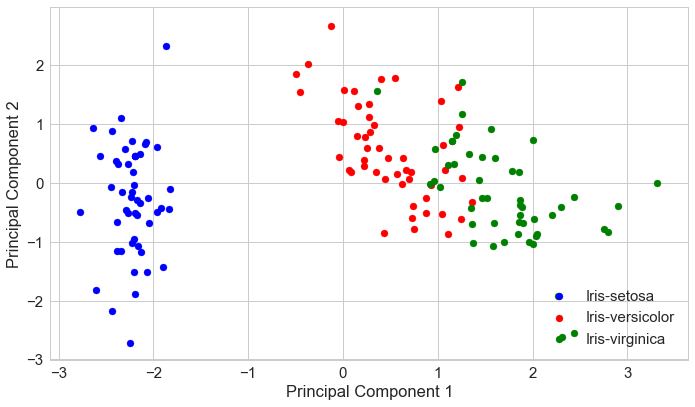

In [34]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 6))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                        ('blue', 'red', 'green')):
        plt.scatter(Y_sklearn[y==lab, 0],
                    -Y_sklearn[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()